In [24]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabriel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

In [26]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [27]:
news_df  = pd.DataFrame({'document': documents})

news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]",'')

news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

news_df.head()

,document,clean_doc
0,Well i'm not sure about the story nad it did s...,well sure about story seem biased. what disagr...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re...","yeah, expect people read faq, etc. actually ac..."
2,Although I realize that principle is not one o...,although realize that principle your strongest...
3,Notwithstanding all the legitimate fuss about ...,notwithstanding legitimate fuss about this pro...
4,"Well, I will have to change the scoring on my ...","well, will have change scoring playoff pool. u..."


In [28]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

news_df


,document,clean_doc
0,Well i'm not sure about the story nad it did s...,well sure story seem biased. disagree statemen...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re...","yeah, expect people read faq, etc. actually ac..."
2,Although I realize that principle is not one o...,"although realize principle strongest points, w..."
3,Notwithstanding all the legitimate fuss about ...,"notwithstanding legitimate fuss proposal, much..."
4,"Well, I will have to change the scoring on my ...","well, change scoring playoff pool. unfortunate..."
...,...,...
11309,"Danny Rubenstein, an Israeli journalist, will ...","danny rubenstein, israeli journalist, speaking..."
11310,\n,
11311,\nI agree. Home runs off Clemens are always m...,agree. home runs clemens always memorable. kin...
11312,I used HP DeskJet with Orange Micros Grappler ...,used deskjet orange micros grappler system6.0....


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])

X.shape

(11314, 1000)

In [30]:
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

20

In [31]:
terms = vectorizer.get_feature_names_out()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("\nTopic "+str(i)+": ",end=' ')
    for t in sorted_terms:
        print(t[0],end=' ')
        print(" ",end=' ')


Topic 0:  like   know   people   think   good   time   thanks   
Topic 1:  thanks   windows   card   drive   mail   file   edu   
Topic 2:  game   team   year   games   season   good   players   
Topic 3:  edu   thanks   mail   com   email   know   soon   
Topic 4:  edu   drive   com   sale   soon   00   government   
Topic 5:  drive   thanks   know   scsi   mail   drives   advance   
Topic 6:  chip   government   like   encryption   clipper   keys   phone   
Topic 7:  like   edu   bike   know   think   sounds   soon   
Topic 8:  card   sale   00   video   good   like   jesus   
Topic 9:  card   people   know   video   edu   think   drivers   
Topic 10:  like   people   windows   drive   game   thanks   file   
Topic 11:  think   thanks   people   mail   good   address   advance   
Topic 12:  know   chip   jesus   game   think   like   clipper   
Topic 13:  know   good   people   windows   file   00   files   
Topic 14:  good   chip   people   clipper   encryption   edu   thanks   
To

/home/gabriel/Desktop/data-science-study/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gabriel/Desktop/data-science-study/venv/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


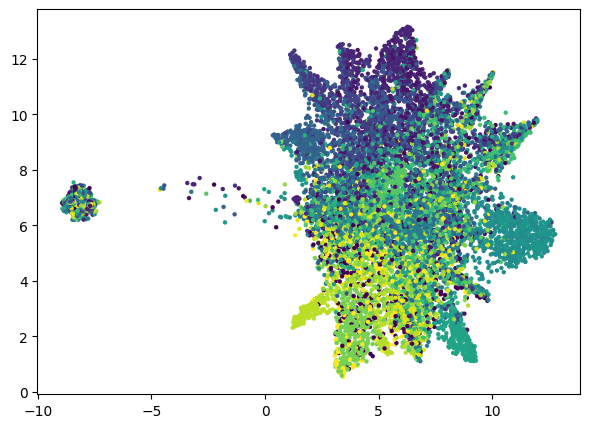

In [32]:
import umap

X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = dataset.target,
s = 10, # size
edgecolor='none'
)
plt.show()